In [2]:
from google.colab import drive
drive.mount('/content/drive')
#/content/drive/MyDrive/iproject/filtered.csv

Mounted at /content/drive


In [5]:
cp /content/drive/MyDrive/iproject/wikifeature.zip .


In [6]:
cp /content/drive/MyDrive/iproject/index.zip .

In [7]:
!unzip index.zip indexed.csv

Archive:  index.zip
  inflating: indexed.csv             


In [8]:
!tail -n10 indexed.csv

Q115782961,"[34199   618  2685   912   337     0     0     0     0     0     0     0
     0     0     0]"
Q115782975,"[11596   912  1856     0     0     0     0     0     0     0     0     0
     0     0     0]"
Q115782981,"[1681 3178   21  347  123 1037    0    0    0    0    0    0    0    0
    0]"
Q115782992,"[475109   6912      0      0      0      0      0      0      0      0
      0      0      0      0      0]"
Q115782995,"[246108    255    501      1    764      2      0      0      0      0
      0      0      0      0      0]"


In [9]:
!unzip wikifeature.zip wikifeature.csv

Archive:  wikifeature.zip
  inflating: wikifeature.csv         


In [10]:
!tail -n10 wikifeature.csv

Q115782911, Q13442814
Q115782924, Q13442814
Q115782929, Q101352
Q115782936, Q13442814
Q115782949, Q13442814
Q115782950, Q13442814
Q115782961, Q13442814
Q115782975, Q13442814
Q115782981, Q445741
Q115782992, Q519608


In [11]:
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import gc
import tensorflow as tf
import pandas as pd
import numpy as np
import re, string
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk
import io
import json
import dask.dataframe as dd
import csv
import ast

from sklearn.model_selection import train_test_split
from ast import literal_eval

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import csv
import tensorflow.keras.backend as K

In [13]:
wiki_feature = pd.read_csv('wikifeature.csv', names=['wikiid', 'wikilabel'],error_bad_lines=False,quoting=csv.QUOTE_NONE,)


In [14]:
print(f"There are {len(wiki_feature)} rows in the dataset.")

There are 97168223 rows in the dataset.


In [ ]:
wiki_feature.head()

,wikiid,wikilabel
0,P102,Q18608871
1,P19,Q18608756 Q18635217 Q26935994 Q18608871 Q9956...
2,P22,Q22964231 Q26935994 Q99567026 Q18647519
3,P39,Q18608871 Q26935994 Q7810129
4,P88,Q18618644


In [ ]:
total_duplicate_titles = sum(wiki_feature["wikiid"].duplicated())
print(f"There are {total_duplicate_titles} duplicate ids.")

There are 12 duplicate ids.


In [ ]:
wiki_data_filtered = wiki_feature.groupby("wikilabel").filter(lambda x: len(x) > 1)
del wiki_feature
wiki_data_filtered.shape



(96958904, 2)

**Convert the string labels to lists of strings**

In [ ]:
xpdf = pd.DataFrame(wiki_feature["wikilabel"][:10])
xpdf

,wikilabel
0,Q18608871
1,Q18608756 Q18635217 Q26935994 Q18608871 Q9956...
2,Q22964231 Q26935994 Q99567026 Q18647519
3,Q18608871 Q26935994 Q7810129
4,Q18618644
5,Q10876391
6,Q21546143
7,Q532 Q1852859
8,Q55488
9,Q532 Q1852859


In [ ]:
chunks = pd.read_csv('wikifeature.csv', names=['wikiid', 'wikilabel'],error_bad_lines=False,quoting=csv.QUOTE_NONE,chunksize= 20000000)
i = 0
while(True):
    try:
        wiki_feature = next(chunks)
        if wiki_feature.shape[0] < 1:
            break;
        wiki_data_filtered = wiki_feature.groupby("wikilabel").filter(lambda x: len(x) > 1)
        del wiki_feature
        wiki_data_filtered["wikilabel"] = wiki_data_filtered["wikilabel"].apply(lambda x: (str(x).lstrip(" ").split(" ")))
        i +=1
        print(i)
        if(i == 1):
          break
        #gc.collect()
    except Exception as e:
        print("error")


In [ ]:
wiki_data_filtered.head()

,wikiid,wikilabel
0,P102,[Q18608871]
4,P88,[Q18618644]
5,Q10000,[Q10876391]
6,Q1000007,[Q21546143]
7,Q100001,"[Q532, Q1852859]"


In [ ]:
chunks = pd.read_csv('indexed.csv', names=['wikiid', 'text'],error_bad_lines=False,quoting=csv.QUOTE_NONE,chunksize= 500000)
i = 0

while(True):
    try:
        indexed = next(chunks)
        if indexed.shape[0] < 1:
            break;
        subset = pd.merge(indexed, wiki_data_filtered, how='inner', on='wikiid')
        del wiki_data_filtered
        del indexed
        
        i +=1
        print(i)
        if(i == 1):
          break
        #gc.collect()
    except Exception as e:
        print("error")


**Multi-label binarization**

In [ ]:
wikilabel = tf.ragged.constant(train_df["wikilabel"].values)
lookup = tf.keras.layers.StringLookup(output_mode="multi_hot")
lookup.adapt(wikilabel)
vocab = lookup.get_vocabulary()


def invert_multi_hot(encoded_labels):
    """Reverse a single multi-hot encoded label to a tuple of vocab terms."""
    hot_indices = np.argwhere(encoded_labels == 1.0)[..., 0]
    return np.take(vocab, hot_indices)


print("Vocabulary:\n")
print(vocab)

Vocabulary:

['[UNK]', "['Q5']", "['Q16521']", "['Q4167836']", "['Q7187']", "['Q8054']", "['Q4167410']", "['Q11266439']", "['Q79007']", "['Q486972']", "['Q482994']", "['Q11424']", "['Q13406463']", "['Q8502']", "['Q532']", "['Q3863']", "['Q4022']", "['Q23397']", "['Q2996394']", "['Q3305213']", "['Q355304']", "['Q4830453']", '"[\'Q277338\'', "['Q17343829']", "['Q27020041']", '"[\'Q427087\'', "['Q16970']", "['Q215380']", "['Q3558970']", "['Q7725634']", "['Q34442']", "['Q22808320']", "['Q23038290']", "['Q55488']", "['Q19389637']", "['Q26211545']", "['Q23442']", "['Q101352']", "['Q13442814']", "['Q484170']", "['Q134556']", "['Q105543609']", "['Q41176']", "['Q18340514']", "['Q14860489']", "['Q7889']", "['Q476028']", '"[\'Q532\'', '"[\'Q4830453\'', "['Q5398426']", "['Q3947']", "['Q5084']", "['Q43229']", '"[\'Q11173\'', "['Q12308941']", "['Q11173']", "['Q112193867']", "['Q21672098']", "['Q1093829']", "['Q811979']", "['Q14350']", "['Q17633526']", "['Q56436498']", "['Q26887310']", "['Q54050']", 

In [ ]:
deduplicated = subset[~subset["text"].duplicated()]

In [ ]:
deduplicated.head()

,wikiid,text,wikilabel
0,Q23,"""[ 472 1936 0 0 0 0 0 0 0...",[Q5]
1,Q23,"""[4190 241 52 0 0 0 0 0 0...",[Q5]
2,Q23,"""[ 271 52038 0 0 0 0 0 ...",[Q5]
4,Q24,"""[ 3292 11408 0 0 0 0 0 ...","[Q15632617, Q15773317]"
5,Q42,"""[2921 1934 0 0 0 0 0 0 0...",[Q5]


In [ ]:
deduplicated.to_csv('model_input.csv', mode='a', index=False, header=False)

In [ ]:
!zip model_input.zip model_input.csv

  adding: model_input.csv (deflated 87%)


In [ ]:
!sudo apt install libtcmalloc-minimal4



Reading package lists... Done
Building dependency tree       
Reading state information... Done
libtcmalloc-minimal4 is already the newest version (2.7-1ubuntu2).
libtcmalloc-minimal4 set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 22 not upgraded.


In [15]:
!export LD_PRELOAD=/usr/lib/x86_64-linux-gnu/libtcmalloc_minimal.so.4

In [16]:
#cp model_input.zip /content/drive/MyDrive/iproject/

!cp /content/drive/MyDrive/iproject/model_input.zip .

In [17]:
!unzip model_input.zip model_input.csv

Archive:  model_input.zip
  inflating: model_input.csv         


In [18]:
model_input_chk = pd.read_csv('model_input.csv', names=['wikiid', 'text', 'wikilabel'],error_bad_lines=False, chunksize= 100000)

model_input = next(model_input_chk)
model_input["wikilabel"] = model_input["wikilabel"].apply(
    lambda x: ast.literal_eval(x)
)



In [19]:
model_input.head()

,wikiid,text,wikilabel
0,Q23,"""[ 472 1936 0 0 0 0 0 0 0...",[Q5]
1,Q23,"""[4190 241 52 0 0 0 0 0 0...",[Q5]
2,Q23,"""[ 271 52038 0 0 0 0 0 ...",[Q5]
3,Q24,"""[ 3292 11408 0 0 0 0 0 ...","[Q15632617, Q15773317]"
4,Q42,"""[2921 1934 0 0 0 0 0 0 0...",[Q5]


In [20]:
def process_vector(line):
    line = str(line)
    linef = ""
    line = re.sub(r"[^A-Za-z0-9]"," ", line)
    #line = re.sub(r"[^p{L}]"," ", line)
    line = re.sub(r"^\W*","", line)
    line = re.sub(r"\W+"," ", line)
    line = re.sub(r"$\W*","", line)
    splitted = str(line).split(" ")[:10]
    line = " ".join(splitted)
    return line
    #return num_list

In [21]:
model_input["text"] = model_input["text"].apply(
    lambda x: process_vector(x)
)

In [22]:
model_input.rename(columns={'text':'x-text-feature','wikilabel':'y-wikitype-multiclass'}).head(10)

,wikiid,x-text-feature,y-wikitype-multiclass
0,Q23,472 1936 0 0 0 0 0 0 0 0,[Q5]
1,Q23,4190 241 52 0 0 0 0 0 0 0,[Q5]
2,Q23,271 52038 0 0 0 0 0 0 0 0,[Q5]
3,Q24,3292 11408 0 0 0 0 0 0 0 0,"[Q15632617, Q15773317]"
4,Q42,2921 1934 0 0 0 0 0 0 0 0,[Q5]
5,Q42,2921 44 1934 0 0 0 0 0 0 0,[Q5]
6,Q42,96 0 0 0 0 0 0 0 0 0,[Q5]
7,Q1868,818 418123 0 0 0 0 0 0 0 0,[Q5]
8,Q1868,818 1276 51510 418123 0 0 0 0 0 0,[Q5]
9,Q1868,818 1276 418123 0 0 0 0 0 0 0,[Q5]


**split the data **

In [23]:
test_split = 0.33

# Initial train and test split.
train_df, test_df = train_test_split(
    model_input,
    test_size=test_split
)

# Splitting the test set further into validation
# and new test sets.
val_df = test_df.sample(frac=0.5)
test_df.drop(val_df.index, inplace=True)

print(f"Number of rows in training set: {len(train_df)}")
print(f"Number of rows in validation set: {len(val_df)}")
print(f"Number of rows in test set: {len(test_df)}")

Number of rows in training set: 67000
Number of rows in validation set: 16500
Number of rows in test set: 16500


In [24]:
wikilabel = tf.ragged.constant(train_df["wikilabel"].values)
lookup = tf.keras.layers.StringLookup(output_mode="multi_hot")
lookup.adapt(wikilabel)
vocab = lookup.get_vocabulary()


def invert_multi_hot(encoded_labels):
    """Reverse a single multi-hot encoded label to a tuple of vocab terms."""
    hot_indices = np.argwhere(encoded_labels == 1.0)[..., 0]
    return np.take(vocab, hot_indices)


print("Vocabulary:\n")
print(vocab)
print(len(vocab))

Vocabulary:

['[UNK]', 'Q5', 'Q4167410', 'Q16521', 'Q11173', 'Q484170', 'Q3863', 'Q747074', 'Q11424', 'Q34770', 'Q1288568', 'Q4022', 'Q70208', 'Q476028', 'Q12140', 'Q262166', 'Q1093829', 'Q4830453', 'Q22808320', 'Q13406463', 'Q532', 'Q486972', 'Q1549591', 'Q27020041', 'Q112193867', 'Q515', 'Q15056993', 'Q482994', 'Q215380', 'Q8054', 'Q3957', 'Q113681859', 'Q26213387', 'Q23038290', 'Q253019', 'Q41710', 'Q94993988', 'Q105543609', 'Q7725634', 'Q1248784', 'Q8502', 'Q34442', 'Q24764', 'Q23442', 'Q3558970', 'Q7889', 'Q42744322', 'Q6881511', 'Q14795564', 'Q577', 'Q55488', 'Q5398426', 'Q15127012', 'Q19832486', 'Q15056995', 'Q891723', 'Q5153359', 'Q29964144', 'Q644371', 'Q35456', 'Q134556', 'Q62049', 'Q67206691', 'Q929833', 'Q7278', 'Q112826905', 'Q1131296', 'Q12089225', 'Q7930989', 'Q67015883', 'Q685309', 'Q15142894', 'Q3191695', 'Q188451', 'Q46970', 'Q2074737', 'Q178561', 'Q928830', 'Q47461344', 'Q6784672', 'Q839954', 'Q523', 'Q186516', 'Q16970', 'Q3146899', 'Q3186692', 'Q205985', 'Q193430', 

In [25]:
sample_label = train_df["wikilabel"].iloc[0]
print(f"Original label: {sample_label}")

label_binarized = lookup([sample_label])
print(f"Label-binarized representation: {label_binarized}")

Original label: ['Q1093829', 'Q13218391']
Label-binarized representation: [[0. 0. 0. ... 0. 0. 0.]]


In [26]:
train_df["text"].values

array(['52579 456 0 0 0 0 0 0 0 0', '2572524 0 0 0 0 0 0 0 0',
       '8504 0 0 0 0 0 0 0 0 0', ..., '1258 604 8316 0 0 0 0 0 0 0',
       '117890 0 0 0 0 0 0 0 0 0', '1111 1665 22506 0 0 0 0 0 0 0'],
      dtype=object)

In [29]:
max_seqlen = 15
batch_size = 128
padding_token = "<pad>"
auto = tf.data.AUTOTUNE

def split_numbers(text):
  vector_list = []
  for num_str in text.values:
    vector = [int(num) for num in num_str.split(" ")][:9]
    #print(len(vector))
    vector_list.append(tf.convert_to_tensor(vector))
  return vector_list



def make_dataset(dataframe, is_train=True):
    labels = tf.ragged.constant(dataframe["wikilabel"].values)
    label_binarized = lookup(labels).numpy()
    dataset = tf.data.Dataset.from_tensor_slices(
        ((split_numbers(dataframe["text"])), label_binarized)
    )
    dataset = dataset.shuffle(batch_size * 10) if is_train else dataset
    return dataset.batch(batch_size)

In [28]:
vocabulary = set()
train_df["text"].str.lower().str.split().apply(vocabulary.update)
vocabulary_size = len(vocabulary)
print(vocabulary_size)

55886


In [30]:
train_dataset = make_dataset(train_df, is_train=True)
validation_dataset = make_dataset(val_df, is_train=False)
test_dataset = make_dataset(test_df, is_train=False)

text_vectorizer = layers.TextVectorization(
    max_tokens=vocabulary_size, ngrams=1, output_mode="tf_idf"
)
def process_tensorvector(line):
  string_v = tf.strings.as_string(line)
  return tf.convert_to_tensor()
    #return text_vectorizer(line)
# `TextVectorization` layer needs to be adapted as per the vocabulary from our
# training set.

train_dataset = train_dataset.map(
    lambda text, label: (text, label), num_parallel_calls=auto
).prefetch(auto)
validation_dataset = validation_dataset.map(
    lambda text, label: (text, label), num_parallel_calls=auto
).prefetch(auto)
test_dataset = test_dataset.map(
    lambda text, label: (text, label), num_parallel_calls=auto
).prefetch(auto)

In [31]:
text_batch, label_batch = next(iter(train_dataset))
for i, text in enumerate(text_batch[60:115]):
    label = label_batch[i].numpy()[None, ...]
    print(type(text))
    print(tf.shape(text))
    print(f"WikiText: {text}")
    print(f"WikiType(s) Multihot: {(label[0])}")
    print(f"WikiType(s): {invert_multi_hot(label[0])}")
    print(" ")

<class 'tensorflow.python.framework.ops.EagerTensor'>
tf.Tensor([9], shape=(1,), dtype=int32)
WikiText: [  747   413 62257     0     0     0     0     0     0]
WikiType(s) Multihot: [0. 1. 0. ... 0. 0. 0.]
WikiType(s): ['Q5']
 
<class 'tensorflow.python.framework.ops.EagerTensor'>
tf.Tensor([9], shape=(1,), dtype=int32)
WikiText: [  118 18292     0     0     0     0     0     0     0]
WikiType(s) Multihot: [0. 1. 0. ... 0. 0. 0.]
WikiType(s): ['Q5']
 
<class 'tensorflow.python.framework.ops.EagerTensor'>
tf.Tensor([9], shape=(1,), dtype=int32)
WikiText: [  232 16853  6334     0     0     0     0     0     0]
WikiType(s) Multihot: [0. 0. 0. ... 0. 0. 0.]
WikiType(s): ['Q11173' 'Q12140' 'Q113681859' 'Q72941151']
 
<class 'tensorflow.python.framework.ops.EagerTensor'>
tf.Tensor([9], shape=(1,), dtype=int32)
WikiText: [289014   2248      0      0      0      0      0      0      0]
WikiType(s) Multihot: [0. 1. 0. ... 0. 0. 0.]
WikiType(s): ['Q5']
 
<class 'tensorflow.python.framework.ops.E

In [33]:
text_batch[:5]

<tf.Tensor: shape=(5, 9), dtype=int32, numpy=
array([[  1004,   5020, 658434,      0,      0,      0,      0,      0,
             0],
       [658328,      0,      0,      0,      0,      0,      0,      0,
             0],
       [    21,      2,     22,   3706,      4,  49313,  55288,      0,
             0],
       [  7232,  40841,  19371,      0,      0,      0,      0,      0,
             0],
       [ 70615,    329,   3124,      0,      0,      0,      0,      0,
             0]], dtype=int32)>

In [34]:
def make_model():

    shallow_mlp_model = keras.Sequential(
        [
            layers.Dense(512, activation="relu"),
            layers.Dense(256, activation="relu",name="wikiembedding256"),
            ##layers.Dense(10, activation="relu", name="wikiembedding10"),
            layers.Dense(lookup.vocabulary_size(), activation="sigmoid"),
        ]  # More on why "sigmoid" has been used here in a moment.
    )
    return shallow_mlp_model

In [37]:
    def weighted_binary_crossentropy(y_true, y_pred):
        one_weight = 0.8
        zero_weight = 2.5

        # Original binary crossentropy (see losses.py):
        # K.mean(K.binary_crossentropy(y_true, y_pred), axis=-1)

        # Calculate the binary crossentropy
        b_ce = K.binary_crossentropy(y_true, y_pred)

        # Apply the weights
        weight_vector = y_true * one_weight + (1. - y_true) * zero_weight
        weighted_b_ce = weight_vector * b_ce

        # Return the mean error
        return K.mean(weighted_b_ce)

In [36]:
def create_weighted_binary_crossentropy(zero_weight, one_weight):

    def weighted_binary_crossentropy(y_true, y_pred):

        # Original binary crossentropy (see losses.py):
        # K.mean(K.binary_crossentropy(y_true, y_pred), axis=-1)

        # Calculate the binary crossentropy
        b_ce = K.binary_crossentropy(y_true, y_pred)

        # Apply the weights
        weight_vector = y_true * one_weight + (1. - y_true) * zero_weight
        weighted_b_ce = weight_vector * b_ce

        # Return the mean error
        return K.mean(weighted_b_ce)

    return weighted_binary_crossentropy

Epoch 1/50
524/524 [==============================] - 16s 28ms/step - loss: 24.8904 - accuracy: 0.2416 - val_loss: 0.3557 - val_accuracy: 0.0727
Epoch 2/50
524/524 [==============================] - 15s 28ms/step - loss: 0.2145 - accuracy: 0.2280 - val_loss: 0.1750 - val_accuracy: 0.2792
Epoch 3/50
524/524 [==============================] - 14s 28ms/step - loss: 0.3824 - accuracy: 0.2335 - val_loss: 0.4812 - val_accuracy: 0.2222
Epoch 4/50
524/524 [==============================] - 14s 27ms/step - loss: 1.2980 - accuracy: 0.2328 - val_loss: 1.0644 - val_accuracy: 0.1727
Epoch 5/50
524/524 [==============================] - 18s 34ms/step - loss: 0.5535 - accuracy: 0.2454 - val_loss: 0.4455 - val_accuracy: 0.3296
Epoch 6/50
524/524 [==============================] - 15s 28ms/step - loss: 0.1591 - accuracy: 0.3414 - val_loss: 0.0596 - val_accuracy: 0.4339
Epoch 7/50
524/524 [==============================] - 15s 28ms/step - loss: 0.6314 - accuracy: 0.2633 - val_loss: 1.6585 - val_accuracy

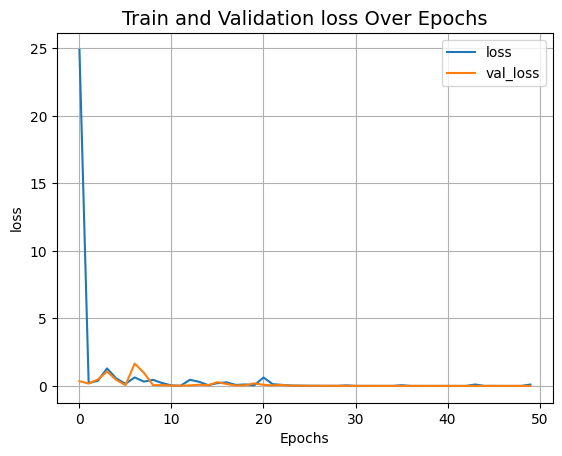

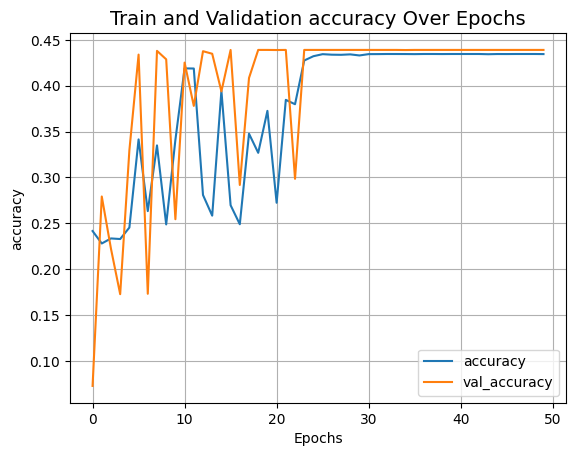

In [38]:
epochs = 50

shallow_mlp_model = make_model()
shallow_mlp_model.compile(
    loss=weighted_binary_crossentropy, optimizer="adam", metrics=['accuracy']
)

history = shallow_mlp_model.fit(
    train_dataset, validation_data=validation_dataset, epochs=epochs
)


def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_result("loss")
plot_result("accuracy")

**Evaluate the model**

In [39]:
_, binary_acc = shallow_mlp_model.evaluate(test_dataset)
print(f"Categorical accuracy on the test set: {round(binary_acc * 100, 2)}%.")

129/129 [==============================] - 1s 10ms/step - loss: 0.0016 - accuracy: 0.4325
Categorical accuracy on the test set: 43.25%.


**Inference**

In [40]:
# Create a model for inference.
model_for_inference = keras.Sequential([shallow_mlp_model])

# Create a small dataset just for demoing inference.
inference_dataset = make_dataset(test_df.sample(100), is_train=False)
text_batch, label_batch = next(iter(inference_dataset))
predicted_probabilities = model_for_inference.predict(text_batch)

# Perform inference.
for i, text in enumerate(text_batch[:5]):
    label = label_batch[i].numpy()[None, ...]
    print(f"Abstract: {text}")
    print(f"Label(s): {invert_multi_hot(label[0])}")
    predicted_proba = [proba for proba in predicted_probabilities[i]]
    top_3_labels = [
        x
        for _, x in sorted(
            zip(predicted_probabilities[i], lookup.get_vocabulary()),
            key=lambda pair: pair[0],
            reverse=True,
        )
    ][:3]
    print(f"Predicted Label(s): ({', '.join([label for label in top_3_labels])})")
    print(" ")

4/4 [==============================] - 0s 3ms/step
Abstract: [3270875       0       0       0       0       0       0       0       0]
Label(s): ['Q3331189' 'Q105420']
Predicted Label(s): (Q5, Q4167410, Q16521)
 
Abstract: [1060054    5276    2614 4815077       0       0       0       0       0]
Label(s): ['Q5']
Predicted Label(s): (Q5, Q4167410, Q16521)
 
Abstract: [430553      0      0      0      0      0      0      0      0]
Label(s): ['Q262166']
Predicted Label(s): (Q5, Q4167410, Q16521)
 
Abstract: [  314 11034 20530   433 40957     0     0     0     0]
Label(s): ['Q193622']
Predicted Label(s): (Q5, Q4167410, Q16521)
 
Abstract: [  2384 162663 735925      0      0      0      0      0      0]
Label(s): ['Q16521']
Predicted Label(s): (Q5, Q4167410, Q16521)
 


In [ ]:
model_for_inference.summary(
)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_5 (Sequential)   (None, 3692)              1085292   
                                                                 
Total params: 1,085,292
Trainable params: 1,085,292
Non-trainable params: 0
_________________________________________________________________


In [41]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 9), dtype=tf.int32, name=None), TensorSpec(shape=(None, 3692), dtype=tf.float32, name=None))>

In [43]:
shallow_mlp_model.layers

In [83]:
from keras import backend as K

inp = shallow_mlp_model.input                                           # input placeholder
for layer in shallow_mlp_model.layers:
  print(layer.name)
  if (layer.name == 'wikiembedding256'):
    weight_vec = layer.get_weights()
  print(layer.weights)




dense
[<tf.Variable 'dense/kernel:0' shape=(9, 512) dtype=float32, numpy=
array([[ 0.13385803,  0.05858618, -0.14751099, ..., -0.00140876,
         0.15022396, -0.02208151],
       [ 0.02179493,  0.0222451 , -0.00069828, ..., -0.10188279,
         0.00895408, -0.118783  ],
       [-0.00091675, -0.06675044, -0.03966738, ..., -0.05689038,
        -0.15079105,  0.00860421],
       ...,
       [ 0.1895281 , -0.14833881,  0.1083524 , ..., -0.02376429,
         0.13104562, -0.01790778],
       [ 0.03359915, -0.19847733,  0.18554908, ..., -0.03814808,
         0.10042968,  0.01406642],
       [-0.10585351, -0.04259942,  0.01058372, ...,  0.05067515,
        -0.1316845 , -0.04444212]], dtype=float32)>, <tf.Variable 'dense/bias:0' shape=(512,) dtype=float32, numpy=
array([ 5.9019737e+00,  5.8470497e+00,  1.8879170e+00,  4.0501800e+00,
        2.8101168e+00, -1.2905504e+00,  4.7055998e-01, -1.8291712e-01,
        1.5120887e+00,  3.2350080e+00,  3.6070836e+00,  4.3396912e+00,
        5.1476293e+0

In [89]:
len(weight_vec[1])

256

In [67]:
train_df['text_vec'] = train_df.text.apply(lambda x : vectorize_number_seq(x))

In [57]:
weight_vec_tf = tf.convert_to_tensor(np.array(weight_vec[0]), dtype=tf.int32, dtype_hint=None, name=None)


In [66]:
def vectorize_number_seq(text):
  return [int(num) for num in text.split(" ")][:9]
  


In [99]:
def dot_product(x, y=weight_vec[1]):
  return np.dot(np.transpose(x),y)
  

In [ ]:
from keras.models import Model

model = ...  # include here your original model

layer_name = 'wikiembedding256'
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)
intermediate_output = intermediate_layer_model.predict(data)